In [106]:
import sys
from typing import Callable

sys.path.append('../')

import random
from helper import *

$$ MSE = \frac{1}{\textit{bath\_size}}\ \sum_{i = 0}^{\textit{bath\_size}} (y_i - \overline{y_i})^2, $$
$$ \text{где } \overline{y_i} = w_0 + w_1 \cdot x + w_2 \cdot x^2 + \dots + w_n \cdot x^n $$
$$ \frac{d MSE}{d w_0} = \frac{-2}{\textit{bath\_size}} \sum_{i = 0}^{\textit{bath\_size}} (y_i - \overline{y_i}) = \sum_{i = 0}^{\textit{bath\_size}} (y_i - (w_0 + w_1 \cdot x + \dots + w_n \cdot x^n)) $$
$$ \frac{d MSE}{d w_1} = \frac{-2}{\textit{bath\_size}} \sum_{i = 0}^{\textit{bath\_size}} x_i \  (y_i - \overline{y_i}) = \sum_{i = 0}^{\textit{bath\_size}} x_i \  (y_i - (w_0 + w_1 \cdot x + \dots + w_n \cdot x^n)) $$
$$ \cdots $$
$$ \frac{d MSE}{d w_n} = \frac{-2}{\textit{bath\_size}} \sum_{i = 0}^{\textit{bath\_size}} x_i^n \  (y_i - \overline{y_i}) = \sum_{i = 0}^{\textit{bath\_size}} x_i^n \  (y_i - (w_0 + w_1 \cdot x + \dots + w_n \cdot x^n)) $$

In [107]:
class stochastic:
    def func(self, x, w):
        pows = [x ** i for i in range(len(w))]
        return w.dot(pows)

    def mse_loss(self, w):
        # y_pred = self.func(self.X, w)
        # mse = np.mean((self.y - y_pred) ** 2)
        # return mse
        
        y_pred = np.array([self.func(x, w) for x in self.X])
        return sum((self.y - y_pred) * (self.y - y_pred)) / len(self.y)

    def mse_loss_grad(self, w):
        # print(self.X.shape, self.y.shape)

        # Choose n random data points from the training set without replacement
        indices = np.random.choice(self.X.shape[0], self.batch_size, replace=False)
        # Getting data from dataset according indices
        X_batch = self.X[indices]
        y_batch = self.y[indices]

        # print(X_batch.shape, y_batch.shape)

        # Compute the gradient of the MSE loss with respect to x for the chosen data points
        y_pred = np.array([self.func(x, w) for x in X_batch])
        X_batch_pow = [X_batch ** i for i in range(len(w))]
        
        # grad = (-2 / self.batch_size) * np.array([sum([X_batch_pow[i][j] * (y_batch[j] - y_pred[j]) for j in range(self.batch_size)]) for i in range(len(w))])
        grad = (-2 / self.batch_size) * np.array([X_batch_pow[i].dot(y_batch - y_pred) for i in range(len(w))])
        # print(f'grad: {grad}')

        # Sum values in rows of grad and divide by n
        # grad_mean = np.mean(grad)
        # print(grad_mean)

        return grad
    
    def __init__(self, X, y, batch_size=2, method='mse'):
        self.X = X
        self.y = y
        self.batch_size = batch_size

        if self.batch_size > X.shape[0]:
            self.batch_size = X.shape[0]

        if method == 'mse':
            self.f = self.mse_loss 
            self.grad = self.mse_loss_grad
        else:
            print('method not found')
        

    def constant_lr_scheduling(epoch, initial_lr):
        return initial_lr

    def gradient_descent(self, x0, lr_scheduling_func=constant_lr_scheduling, initial_lr=0.1, max_epochs=100, eps=1e-5, minimum = 0.0, apply_min=False, apply_value=True):
        """
        Cтохастический градиентный спуск для поиска минимума функции.

        Аргументы:
            x0 (list): Начальную точка, с которой начинается поиск.
            initial_lr (float): learning_rate - Начальная скорость обучения или шаг градиентного спуска.
            max_epochs (int): Максимальное количество эпох или итераций для выполнения алгоритма.
            minimum (float): Минимум функции.
            epsilon (float): Малое число, используемое как критерий останова для алгоритма.
        Возвращает:
            Список всех точек, посещенных во время алгоритма.
        """
        return custom_gradient_descent_with_lr_scheduling(self.f, self.grad, x0, lr_scheduling_func, initial_lr, max_epochs, eps, minimum, apply_min, apply_value)
    
    def get_loss_history(self, results):
        loss_history = []

        for i in range(len(results)):
            loss_history.append(self.f(results[i]))

        return loss_history

In [108]:
import torch
import numpy as np

def f_m(x, w):
    pows = [x ** i for i in range(len(w))]
    return w.dot(pows)

def f(x, w):
    return math.sin(2*x)

def generate_dataset(X, Y, dots_count, radius):
    dataset_X = []
    dataset_Y = []

    x_min = min(X) - radius
    y_min = min(Y) - radius
    x_max = max(X) + radius
    y_max = max(Y) + radius

    print('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X = torch.tensor(X, dtype=torch.float32).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).to(device)

    while len(dataset_X) < dots_count:
        x_rand = torch.empty(1).uniform_(x_min, x_max).to(device)
        y_rand = torch.empty(1).uniform_(y_min, y_max).to(device)

        within_radius = (x_rand - X)**2 + (y_rand - Y)**2 <= radius**2
        if torch.any(within_radius):
            dataset_X.append([x_rand.item()])
            dataset_Y.append([y_rand.item()])

    return np.array(dataset_X), np.array(dataset_Y)

# Параметры
density = 8000
dots_count = 1000
dist = 1.6
radius = 0.1

# Генерируем случайные точки
weights = np.array([15, 3, 4, -2])
X = np.linspace(-dist, dist, density)
Y = np.array([f(x, weights) for x in X])

# Генерируем датасет
dataset_X, dataset_Y = generate_dataset(X, Y, dots_count, radius)


cpu


Коэффициенты уравнения прямой:
y = 15x^0 + 3x^1 + 4x^2 + -2x^3


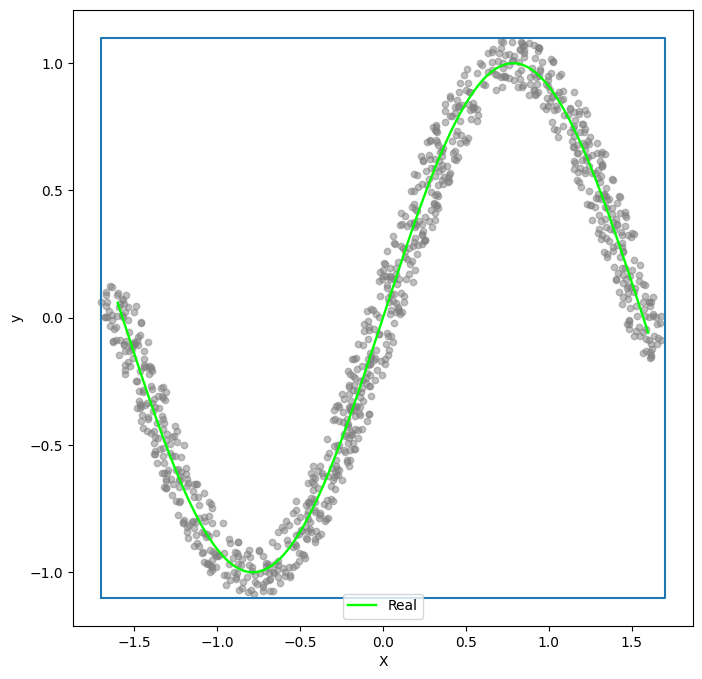

In [109]:
print("Коэффициенты уравнения прямой:")
print(f"y = {' + '.join([f'{str(weights[i])}x^{i}' for i in range(len(weights))])}")

plt.style.use('default')
_ = plt.figure(figsize=(8, 8))


# Задаем координаты вершин прямоугольника
x = [min(X) - radius, min(X) - radius, max(X) + radius, max(X) + radius, min(X) - radius]
y = [min(Y) - radius, max(Y) + radius, max(Y) + radius, min(Y) - radius, min(Y) - radius]

# Рисуем прямоугольник
plt.plot(x, y)


plt.scatter(dataset_X, dataset_Y, color='gray', alpha=0.5, s=20.8, antialiased=True)
plt.plot()
plt.xlabel('X')
plt.ylabel('y')
plt.plot(X, Y, label='Real', color='lime', antialiased=True, linewidth=1.7)

# plt.plot(X, results[-1][0] * X + real_bias, label='SGD', linewidth=1.5)
# print("Вычисленные коэффициенты уравнения прямой SGD:")
# print(f"y = {results[-1][0]:.3f} * x + {real_bias:.3f}")

plt.legend()
plt.show()

In [110]:
def l1_regu(new_args_func: Callable[[np.ndarray, float, np.ndarray], np.ndarray],
            coef: float) -> Callable[[np.ndarray, float, np.ndarray], np.ndarray]:
    def apply(prev_args: np.ndarray, learning_rate: float, grad: np.ndarray) -> np.ndarray:
        grad += coef * np.array([1 if arg > 0 else -1 for arg in prev_args])
        return new_args_func(prev_args, learning_rate, grad)

    return apply


def l2_regu(new_args_func: Callable[[np.ndarray, float, np.ndarray], np.ndarray],
            coef: float) -> Callable[[np.ndarray, float, np.ndarray], np.ndarray]:
    def apply(prev_args: np.ndarray, learning_rate: float, grad: np.ndarray) -> np.ndarray:
        grad += coef * 2 * prev_args
        return new_args_func(prev_args, learning_rate, grad)

    return apply


def elastic(new_args_func: Callable[[np.ndarray, float, np.ndarray], np.ndarray],
            coef: float, l1_coef: float, l2_coef: float) -> Callable[[np.ndarray, float, np.ndarray], np.ndarray]:
    def apply(prev_args: np.ndarray, learning_rate: float, grad: np.ndarray) -> np.ndarray:
        l1_regr = l1_coef * np.array([1 if arg > 0 else -1 for arg in prev_args])
        l2_regr = l2_coef * 2 * prev_args
        grad += coef * l1_regr + (1 - coef) / 2 * l2_regr
        return new_args_func(prev_args, learning_rate, grad)

    return apply


def polynomial_stochastic_gradient_descent(dots: np.ndarray, batch_size: int, initial_weights: np.ndarray,
                                           learning_rate: float,
                                           l1: float = 0, l2: float = 0, elastic: float = 0, epochs_count=2000,
                                           convergence_tolerance=1e-4, tolerance=1e-3):
    dim = len(initial_weights)
    visited_points = [initial_weights]
    dots_i = list(range(len(dots)))
    prev_args = initial_weights
    converges = False

    for _ in range(epochs_count):
        if converges:
            break

        random.shuffle(dots_i)

        for i in range((len(dots) + batch_size - 1) // batch_size):
            minibatch_i = dots_i[i * batch_size: (i + 1) * batch_size]
            minibatch_dots = [dots[i] for i in minibatch_i]
            grad = np.zeros(dim, dtype=float)
            grad_func = func_utils.grad_func(prev_args, learning_rate)

            for dot in minibatch_dots:
                grad += grad_func(dot[0], dot[1])

            l1_regr = l1 * np.array([1 if arg > 0 else -1 for arg in prev_args])
            l2_regr = l2 * 2 * prev_args

            if abs(elastic) > tolerance:
                grad += elastic * l1_regr + (1 - elastic) / 2 * l2_regr
            else:
                grad += l1_regr + l2_regr

            new_args = prev_args - learning_rate * grad

            if all(abs(new_args - prev_args) < convergence_tolerance):
                converges = True
                break
                
            visited_points.append(new_args)
            prev_args = new_args

    return np.array(visited_points)

answer: [-0.00086967  0.74831821 -0.00136966 -0.18829439]
n points: 500
mse: 0.1290000790486031


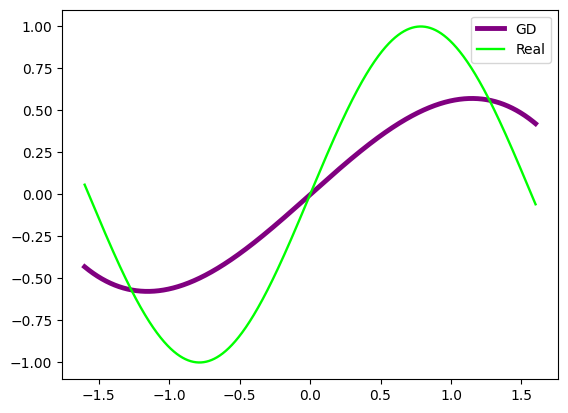

In [111]:
bath_size = 750
degree = len(weights)

sgd = stochastic(X, Y, batch_size=bath_size)
result = sgd.gradient_descent(np.zeros(degree, dtype=float), max_epochs=500, initial_lr=0.005, apply_min=True, apply_value=False)
print(f'answer: {result[-1]}')

Answer_Y = np.array([f_m(x, result[-1]) for x in X])
print("n points:", len(result))
print("mse:", sgd.mse_loss(result[-1]))
plt.plot(X, Answer_Y, label='GD', color='purple', antialiased=True, linewidth=3.5)
plt.plot(X, Y, label='Real', color='lime', antialiased=True, linewidth=1.7)
plt.legend()
plt.show()
